In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

<b>1. Wczytać plik csv.</b>

In [2]:
df = pd.read_csv("dane.csv")

In [3]:
df.head()

,client_id,profit,closed_volume,side,reg_date
0,223946,165.496791,9917,SELL,1.474020e+12
1,223946,55.195228,9953,SELL,1.474020e+12
2,223946,713.153400,10000,SELL,1.474020e+12
3,223961,3.262358,1975,BUY,1.484050e+12
4,223961,-317.982441,3000,BUY,1.484050e+12


<b> 2. Znaleźć client_id, closed_volume oraz reg_date dla transakcji, na której był największy profit. </b>

In [4]:
max_profit_row = df[df['profit']== df['profit'].max()]
print(max_profit_row)

        client_id       profit  closed_volume  side      reg_date
402816     224050  1917.008043           1000  SELL  1.533160e+12


In [5]:
max_profit_row[['client_id','closed_volume','reg_date']]

,client_id,closed_volume,reg_date
402816,224050,1000,1.533160e+12


<b>3. Stworzyć nową tabelę z pogrupowanymi danymi. Kolejne kolumny to:</b>
- client_id
- suma profitu danego klienta
- średni wolumen na transakcji
- liczba transakcji klienta
- data rejestracji klienta

<b>przykładowy wiersz: [client_id, sum(profit), avg(closed_volume), reg_date] = [123156, 1235, 111, 1500000000000]
</b>

In [6]:
df2 = df.groupby('client_id').agg({'profit': 'sum', 'closed_volume': ['mean','count'], 'reg_date':'min' })

In [7]:
df2.columns = ['sum(profit)', 'avg(closed_volume)', 'count(transactions)', 'reg_date']

In [8]:
df2.head()

,sum(profit),avg(closed_volume),count(transactions),reg_date
client_id,,,,
143546,-101.903273,3086.500000,10,1.445370e+12
143565,-2347.015062,4.160000,25,1.452440e+12
143566,-1753.888235,6421.741497,147,1.481560e+12
144015,-464.168235,1000.000000,1,1.496150e+12
223841,-996.534271,1.053571,56,1.462880e+12


<b>4. Stworzyć zmienną reg_date_bin, która przyjmuje 1 gdy data rejestracji jest większa niż 1515000000000,
 i 0 w przeciwnym przypadku.</b>

In [9]:
df['reg_date_bin']=df['reg_date'].apply(lambda x: 1 if x > 1515000000000 else 0)

<b> 5. Stworzyć model regresji liniowej, gdzie zmienną zależną będzie suma profitu, a niezależną średni wolumen,
liczba transakcji oraz binarna zmienna reg_date_bin (w modelu uwzględnić stałą). Sprawdzić istotność zmiennych.</b>

In [10]:
# y: sum(profit)
# x : avg(closed_volume) , count(transactions) , reg_date_bin, constant

In [11]:
df2['reg_date_bin']=df2['reg_date'].apply(lambda x: 1 if x > 1515000000000 else 0)

In [12]:
import statsmodels.api as sm

In [13]:
X = df2[['avg(closed_volume)','count(transactions)', 'reg_date_bin']] 
Y = df2['sum(profit)']
X = sm.add_constant(X) # add a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            sum(profit)   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3283.
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           4.02e-69
Time:                        23:17:15   Log-Likelihood:                -787.89
No. Observations:                  67   AIC:                             1584.
Df Residuals:                      63   BIC:                             1593.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3078.4170   5

In [14]:
print("""H0: There is little to no statistical relationship between dependent and independent variable.
If P value less than the confidence level, assume 0.05, there is a statistically significant relationship between the term and the response.\n""")
print ("Variables significance test results: \n")
print ("As we can see from the above summary, assuming 0.05 confidence level,")
print ("We can reject H0 for avg(closed_volume) and count(transactions).")
print ("On the other hand, we fail to reject H0 for const and reg_date_bin .")

H0: There is little to no statistical relationship between dependent and independent variable.
If P value less than the confidence level, assume 0.05, there is a statistically significant relationship between the term and the response.

Variables significance test results: 

As we can see from the above summary, assuming 0.05 confidence level,
We can reject H0 for avg(closed_volume) and count(transactions).
On the other hand, we fail to reject H0 for const and reg_date_bin .


<b>6. Sprawdzić dopasowanie modelu do danych za pomocą jednej (dowolnie wybranej) miary.</b>


In [15]:
ProbF= 4.02e-69 
print ("Model fit test: \n") 
print ("The Prob (F-statistic) in the model:", "{:.69f}".format(ProbF) ,"is much lower than significance level 0.005.") 
print("\nThis implies that the regression model fits the data way better than model with no independent variables")

Model fit test: 

The Prob (F-statistic) in the model: 0.000000000000000000000000000000000000000000000000000000000000000000004 is much lower than significance level 0.005.

This implies that the regression model fits the data way better than model with no independent variables


<b>7. Dopasować rozkład normalny do zmiennej profit w pierwotnym pliku dane (polecamy utworzyć obiekt 
 norm z pakietu scipy.stats, dla rozjaśnienia sytuacji polecamy również wykonać histogram profitu z transakcji).
 Na tej podstawie policzyć prawdopodobieństwo, że profit z transakcji będzie większy niż 1000. </b>

In [16]:
profit_dist = list(df['profit'])

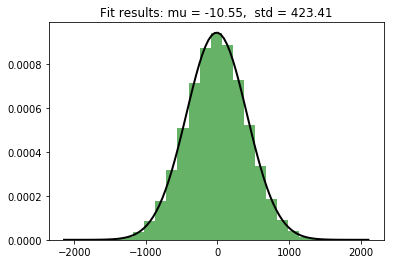

In [17]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(profit_dist)

# Plot the histogram.
plt.hist(profit_dist, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [18]:
#Probability of profit more than 1000 from scipy:    
less_than_value = norm.cdf(1000, loc = -10.55, scale = 423.41)
# 1- Pr(less_than_value) for Pr(more_than_value)
more_than_value = 1-less_than_value
print ("Probability of profit being more than 1000 estimated at" , "{:.4f}".format((more_than_value)),"%" )

Probability of profit being more than 1000 estimated at 0.0085 %


<b>Bonus: </b>

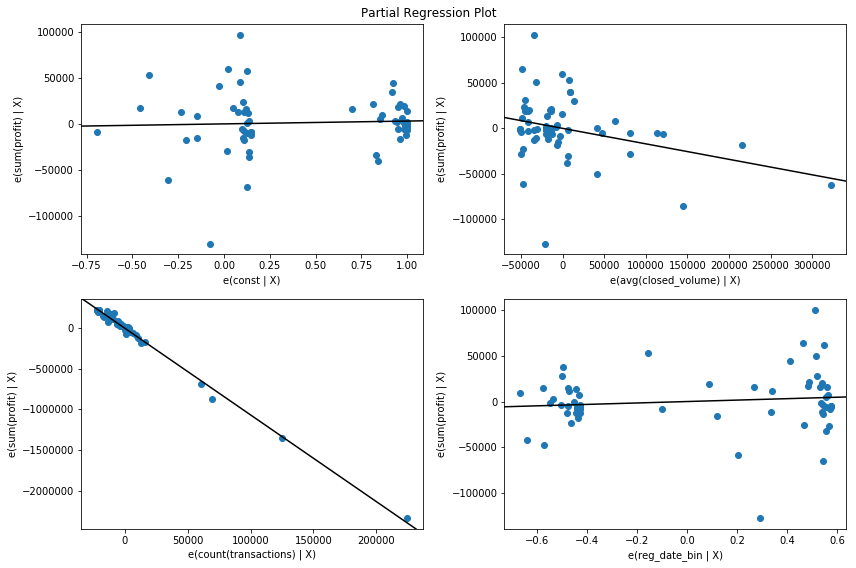

In [19]:
#Graphial representation of variables regression showing high correlation of transaction count and profits
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

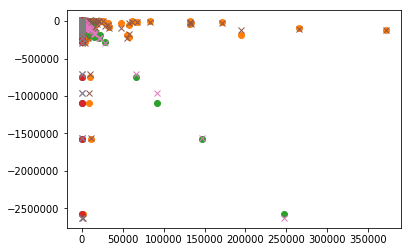

In [20]:
# Plotted data below and R^2 at 0.994 confirms a good fit of the model
plt.plot(X, Y, 'o', label="data")
plt.plot(X, model.fittedvalues, 'x', label="OLS")